In [1]:
import numpy as np
from scipy.integrate import quad
from random import uniform, gauss
import my_functions as tp
import h5py
import warnings
warnings.filterwarnings("ignore")
from my_functions import *
from my_functions import f_of_x

############################################################################################################
################################################## SETTINGS ################################################
############################################################################################################

# SWITCHES

reuse_tables = False # reuse integration tables. Make sure you are using the same parameters
Parallel = False # Use multiple threads (not yet implemented)

have_gas = True
have_DM = False
have_stars = False
# choose species to include in simulation

sample_DM = True 
# use this along with have_DM = True if you want to include the DM potential when 
# calculating the gas temperatures but don't want to sample the DM particles themselves.
# This is meant for running the gas in an external DM potential.
# If have_DM is false, then this has no effect. 

sample_gas = True
# same as sample_DM but for the gas particles, i.e. set this false if you want to run DM with an
# analytic baryon potential

mirrored_halo = True
# sample particles in pairs which are mirrored at the origin.
# This makes the total initial momentum and center of mass exactly zero, but might 
# create instabilities in very compact systems

read_gas_data = False
gas_data_path = 'gas_IC_relaxed_normalized_1e5.npy'
# Use this if you use a relaxation algorithm. 
# Only the coordinates will be used. The velocities will be set back to zero 
# and the temperatures will be re-calculated.

let_halo_contract = True 
# In this case, the halo velocities will be calculated from the DM potential only.
# This leads to unstable initial conditions. In the simulation, the halo will then 
# contract onto the baryon distribution. This approach is used in fluid models
# i.e. Zhong et al. 2023

# PARAMS

#gas_profile = 'Burkert'
gas_profile = 'Hernquist'
gas_profile = 'Beta_model' 

dm_profile = 'NFW'
#dm_profile = 'tNFW' # truncated NFW profile 

filename = 'dianoga_16_gas_only'

#Create_sim_folder = True
#sim_parent_dir = '../dSph_stability_tests/'
#sim_name = 'r_max_10'
#gadget_location = '../dSph_stability_tests/dSph_normal/P-Gadget3'

N_sampling = 1000 # size of the arrays created in numerical integration
#N_sampling=100

N_part_gas = int(1e5) # number of particles to sample
#r_s_gas = 0.39 # normal dsph
#r_s_gas = 0.19 # compact dSPh

# dianoga SIDM beta model cluster
beta = 0.81
rho_s_gas = 1.002201e-4
r_s_gas = 2.65

#N_part_gas = int(1e2)
#r_s_gas = 0.787 # diffuse dSph
#r_s_gas = 194.78 # cluster
#rho_s_gas = 0.26 # normal dsph
#rho_s_gas = 2.16 # compact dSph
#rho_s_gas = 0.033 # diffuse dSph
#rho_s_gas = 9.72e-5 # cluster
#r_s_gas = 0.77 # SIDM10+baryonM Zhong et al 2023
#rho_s_gas = 3.6e-2 # SIDM10+baryonM Zhong et al 2023

#N_part_stars = int(1e3)
r_s_stars = 0.39
rho_s_stars = 0.26
r_max_stars = 10

N_part_DM = int(1e7)
r_max_DM = 15 # maximum sampling distance of the system in units of r_s_DM
truncation_radius_dm = 2 # when tNFW profile is used
r_max_gas = 5.11*10
#r_s_DM = 9.5 # dSph Jiang et al
#rho_s_DM = 6.228e-4 # dSph Jiang et al
r_s_DM = 9.1 # Zhong et al 2023
rho_s_DM = 6.9e-4 # Zhong et al 2023
#r_s_DM = 0.39
#rho_s_DM = 0.26
#r_s_DM = 389.31 # cluster
#rho_s_DM = 1.14e-4 #cluster

############################################################################################################
################################################ FUNCTIONS #################################################
############################################################################################################

def find_closest(array, value):
    # find index of 'array' entry which is closest to 'value'
    diff = array - value
    idx = np.abs(diff).argmin()
    return idx, diff[idx]

def Burkert(r, r_s, rho_s):
    x = r/r_s
    return rho_s/((1 + x)*(1 + x**2))

def mass_Burkert(r):
    def dMdr(r):
        return 4 * np.pi * Burkert(r) * r**2
    return quad(dMdr, 0, r)[0]

def tNFW(r, r_s, rho_s, t):
    # t is the truncation radius in units of r_s
    x = r/r_s
    return (rho_s/(x * (1+x)**2)) * (t**2/(x**2 + t**2)) 

def dMdr_tNFW(r, r_s, rho_s, t):
    return 4 * np.pi * tNFW(r, r_s, rho_s, t) * r**2

def mass_tNFW(r, r_s, rho_s, t):
    return quad(dMdr_tNFW, 0, r, args=(r_s, rho_s, t))[0]

def NFW(r, r_s, rho_s):
    x = r/r_s
    return rho_s/(x * (1+x)**2)

def mass_NFW(r, r_s, rho_s):
    # return mass enclosed in r
    return 4 * np.pi * rho_s * r_s**3 * ( np.log( (r_s + r) /r_s ) - r/(r_s + r))

def Hernquist(r, r_s, rho_s):
    x = r/r_s
    return rho_s/(x * (1+x)**3)

def mass_Hernquist(r, r_s, rho_s):
    # return mass enclosed in r
    x = r/r_s
    return 2 * np.pi * rho_s * r_s**3 * x**2/(x+1)**2

def Beta_model(r, rho_0, r_c, beta):
    return rho_0 * (1 + (r/r_c)**2 )**(-3*beta/2)

def mass_Beta_model(r, rho_0, r_c, beta):
    return quad(lambda r_:4*np.pi*r_**2*Beta_model(r_, rho_0, r_c, beta), 0, r)[0]

def inverse_CPD_Hernquist(x, r_s, rho_s, r_max):
    # assumes r_max in kpc
    x *= (r_max/r_s)**2/( (r_max/r_s) +1)**2
    return - r_s * np.sqrt(x)/(np.sqrt(x)-1)

if gas_profile == 'Burkert':
    def mass_gas(r):
        return mass_Burkert(r)
    def density_gas(r):
        return Burkert(r)
    
elif gas_profile == 'Hernquist':
    def mass_gas(r):    
        return mass_Hernquist(r, r_s_gas, rho_s_gas)
    def density_gas(r):
        return Hernquist(r, r_s_gas, rho_s_gas)

elif gas_profile == 'Beta_model':
    def mass_gas(r):
        return mass_Beta_model(r, rho_s_gas, r_s_gas, beta)
    def density_gas(r):
        return Beta_model(r, rho_s_gas, r_s_gas, beta)
    
def mass_stars(r):
    return mass_Hernquist(r, r_s_stars, rho_s_stars)
def density_stars(r):
    return Hernquist(r, r_s_stars, rho_s_stars)

if dm_profile == 'NFW':
    def mass_dm(r):
        return mass_NFW(r, r_s_DM, rho_s_DM)
    def density_dm(r):
        return NFW(r, r_s_DM, rho_s_DM)
elif dm_profile == 'tNFW':
    def density_dm(r):
        return tNFW(r, r_s_DM, rho_s_DM, truncation_radius_dm)
    def mass_dm(r):
        return mass_tNFW(r, r_s_DM, rho_s_DM, truncation_radius_dm)

def mean_particle_separation_gas(r):
    N = mass_gas(r)/part_mass_gas # number of particles enclosed in r
    n = 3*N/(4 * np.pi * r**3) # average number density
    return n**(-1/3) # mean seperation

def mean_particle_separation_DM(r):
    N = mass_dm(r)/part_mass_DM # number of particles enclosed in r
    n = 3*N/(4 * np.pi * r**3) # average number density
    return n**(-1/3) # mean seperation

def mean_particle_separation_stars(r):
    N = mass_stars(r)/part_mass_stars
    n = 3 *N/(4 * np.pi * r**3)
    return n**(-1/3)
    
def dpdr_gas(r):
    return  43000 * density_gas(r) * total_mass(r)/r**2

def temp_gas(r):
    p = quad(dpdr_gas, r, np.inf)[0]
    u = (3/2) * p / density_gas(r)
    return u

def total_mass(r):
    return have_DM * mass_dm(r) + have_gas * mass_gas(r) + have_stars * mass_stars(r)

if let_halo_contract:
    def dpdr_halo(r):
        return  43000 * density_dm(r) * mass_dm(r)/r**2
else:
    def dpdr_halo(r):
        return 43000 * density_dm(r) * total_mass(r)/r**2

def sigma_2_halo(r):
    p = quad(dpdr_halo, r, np.inf)[0]
    sigma_2 = p / density_dm(r)
    return sigma_2

def sigma_2_stars(r):
    def dpdr(r):
        return 43000 * density_stars(r) * total_mass(r)/r**2
    p = quad(dpdr, r, np.inf)[0]
    sigma_2 = p / density_stars(r)
    return sigma_2
        
# this is just for printing out the progress in a nice way
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, 
                      fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
        
#############################################################################################################
######################################## CALCULATE INTEGRATION TABLES #######################################
#############################################################################################################

if not read_gas_data:
    r_max_gas = r_max_gas * r_s_gas
else:
    coords_gas = np.load(gas_data_path) * r_s_gas
    c = np.transpose(coords_gas)
    rs = np.sqrt(c[0]**2 + c[1]**2 + c[2]**2)
    r_max_gas = np.amax(rs)

r_max_DM = r_max_DM * r_s_DM
r_max_stars = r_max_stars * r_s_stars

r_arr_gas = np.logspace(-9+np.log10(r_max_gas), np.log10(r_max_gas), N_sampling)
r_arr_DM = np.logspace(-9+np.log10(r_max_DM), np.log10(r_max_DM), N_sampling)
r_arr_stars = np.logspace(-9+np.log10(r_max_stars), np.log10(r_max_stars), N_sampling)
    
if have_gas and sample_gas:
    M_arr_gas = [mass_gas(r) for r in r_arr_gas]
    CPD_arr_gas = M_arr_gas/np.amax(M_arr_gas)
    
    print('Calculating gas temperature profile... ')

    temp_arr = np.zeros(N_sampling)

    for i, r in enumerate(r_arr_gas):
        printProgressBar(i, len(r_arr_gas), length=50)
        temp_arr[i] = temp_gas(r)
            
if have_stars:
    print('Calculating star velocity dispersion profile... ')

    sigma2_arr_stars = np.zeros(N_sampling)

    for i, r in enumerate(r_arr_stars):
        printProgressBar(i, len(r_arr_stars), length=50)
        sigma2_arr_stars[i] = sigma_2_stars(r)

if have_DM and sample_DM:
    M_arr_DM = [mass_dm(r) for r in r_arr_DM]
    CPD_arr_DM = M_arr_DM/np.amax(M_arr_DM)
        
    print('Calculating DM velocity dispersion profile...')

    sigma2_arr_dm = np.zeros(N_sampling)

    for i, r in enumerate(r_arr_DM):
        printProgressBar(i, len(r_arr_DM), length=50)
        sigma2_arr_dm[i] = sigma_2_halo(r)

#############################################################################################################
############################################# SAMPLE PARTICLES ##############################################
#############################################################################################################

if have_gas and sample_gas:
    
    print('')
    print('Sampling gas ...')

    if not read_gas_data:
        coords_gas = np.zeros([N_part_gas, 3])
    vels_gas = np.zeros([N_part_gas, 3])
    temps_gas = np.zeros(N_part_gas)
    
    if mirrored_halo and not read_gas_data:
        # N_part must be an even number:
        if N_part_gas % 2 != 0:
            N_part_gas += 1
        N_sample = int(N_part_gas/2)
    else:
        N_sample = N_part_gas

    for i in range(N_sample):
        if i%1000 == 0:
            printProgressBar(i, N_part_gas, length=50)
        
        if not read_gas_data:
            # sample radius
            if gas_profile == 'Hernquist':
                x = uniform(0, 1)
                r = inverse_CPD_Hernquist(x, r_s_gas, rho_s_gas, r_max_gas)
            else:
                x = uniform(0, 1)
                idx, diff = find_closest(CPD_arr_gas, x)
                r = r_arr_gas[idx]
                #f = f_of_x(r_arr_gas, CPD_arr_gas, x, interpolation='linear')

            # sample angular position 
            phi = uniform(0, 1) * 2 * np.pi
            x = uniform(0.0,1.0)-0.5
            theta = np.arccos(-2.0*x)

            # set coordinates
            coords_gas[i][0] = r*np.sin(theta)*np.cos(phi)
            coords_gas[i][1] = r*np.sin(theta)*np.sin(phi)
            coords_gas[i][2] = r*np.cos(theta)
        else:
            c = np.transpose(coords_gas[i])
            r = np.sqrt(c[0]**2 + c[1]**2 + c[2]**2)

        # set temperature
        idx, diff = find_closest(r_arr_gas, r)
        #temps_gas[i] = temp_arr[idx]
        temps_gas[i] = f_of_x(temp_arr, r_arr_gas, r, interpolation='linear')

        if mirrored_halo and not read_gas_data:
            # find positions of mirror particles
            coords_gas[N_sample + i] = -coords_gas[i]
            temps_gas[N_sample +i] = temps_gas[i]
    
if have_DM and sample_DM:
    print('')
    print('Sampling DM ...')

    if mirrored_halo:
        # N_part_DM must be an even number:
        if N_part_DM % 2 != 0:
            N_part_DM += 1
        N_sample = int(N_part_DM/2)
    else:
        N_sample = N_part_DM
        
    coords_DM = np.zeros([N_part_DM,3])
    vels_DM = np.zeros([N_part_DM,3])

    for i in range(N_sample):
        if i%1000 == 0:
            printProgressBar(i, N_sample, length=50)

        # sample radius 
        x = uniform(0, 1)
        #idx, diff = find_closest(CPD_arr_DM, x)
        #r = r_arr_DM[idx]
        r = f_of_x(r_arr_DM, CPD_arr_DM, x, interpolation='linear')

        # sample angular position 
        phi = uniform(0, 1) * 2 * np.pi
        x = uniform(0.0,1.0)-0.5
        theta = np.arccos(-2.0*x)

        # convert to carthesian coordinates
        coords_DM[i][0] = r*np.sin(theta)*np.cos(phi)
        coords_DM[i][1] = r*np.sin(theta)*np.sin(phi)
        coords_DM[i][2] = r*np.cos(theta)

        # find velocity dispersion by matching to v_disp array
        #idx, diff = find_closest(r_arr_DM, r)
        #sigma2 = sigma2_arr_dm[idx]
        sigma2 = f_of_x(sigma2_arr_dm, r_arr_DM, r)
        sigma = np.sqrt(sigma2)

        vels_DM[i][0] = gauss(0, sigma)
        vels_DM[i][1] = gauss(0, sigma)
        vels_DM[i][2] = gauss(0, sigma)
        
        if mirrored_halo:
            # find positions of mirror particles
            coords_DM[N_sample + i] = -coords_DM[i]
            vels_DM[N_sample + i] = -vels_DM[i]
            
if have_stars:
    print('')
    print('Sampling stars ...')

    if mirrored_halo:
        # N_part must be an even number:
        if N_part_stars % 2 != 0:
            N_part_stars += 1
        N_sample = int(N_part_stars/2)
    else:
        N_sample = N_part_stars
        
    coords_stars = np.zeros([N_part_stars,3])
    vels_stars = np.zeros([N_part_stars,3])

    for i in range(N_sample):
        if i%1000 == 0:
            printProgressBar(i, N_sample, length=50)

        # sample radius 
        x = uniform(0, 1)
        r = inverse_CPD_Hernquist(x, r_s_stars, rho_s_stars, r_max_stars)

        # sample angular position 
        phi = uniform(0, 1) * 2 * np.pi
        x = uniform(0.0,1.0)-0.5
        theta = np.arccos(-2.0*x)

        # find coordinates
        coords_stars[i][0] = r*np.sin(theta)*np.cos(phi)
        coords_stars[i][1] = r*np.sin(theta)*np.sin(phi)
        coords_stars[i][2] = r*np.cos(theta)

        # find square velocity dispersion
        #idx, diff = find_closest(r_arr_DM, r)
        #sigma2 = sigma2_arr_stars[idx]
        sigma2 = f_of_x(sigma_2_stars, r_arr_stars, r, interpolation='linear')
        sigma = np.sqrt(sigma2)

        vels_stars[i][0] = gauss(0, sigma)
        vels_stars[i][1] = gauss(0, sigma)
        vels_stars[i][2] = gauss(0, sigma)
        
        if mirrored_halo:
            # find positions of mirror particles
            coords_stars[N_sample + i] = -coords_stars[i]
            vels_stars[N_sample + i] = -vels_stars[i]

# get total masses:
total_mass_gas = mass_gas(r_max_gas)
total_mass_DM = mass_dm(r_max_DM)
total_mass_stars = mass_stars(r_max_stars)

#############################################################################################################
############################################# SAVE TO HDF5 FILE #############################################
#############################################################################################################

print(' ')
print('Saving ...',end='')

data = []

if have_gas and sample_gas:
    part_mass_gas = total_mass_gas/N_part_gas
    data_gas = {}
    data_gas['count'] = N_part_gas
    data_gas['PartMass'] = part_mass_gas
    data_gas['PartType'] = 0
    data_gas['Coordinates'] = coords_gas
    data_gas['Velocities'] = vels_gas
    data_gas['InternalEnergy'] = temps_gas
    data.append(data_gas)

if have_DM and sample_DM:
    part_mass_DM = total_mass_DM/N_part_DM
    data_DM = {}
    data_DM['count'] = N_part_DM
    data_DM['PartMass'] = part_mass_DM
    data_DM['PartType'] = 1
    data_DM['Coordinates'] = coords_DM
    data_DM['Velocities'] = vels_DM
    data.append(data_DM)
    
if have_stars:
    part_mass_stars = total_mass_stars/N_part_stars
    data_stars = {}
    data_stars['count'] = N_part_stars
    data_stars['PartMass'] = part_mass_stars
    data_stars['PartType'] = 4
    data_stars['Coordinates'] = coords_stars
    data_stars['Velocities'] = vels_stars
    data.append(data_stars)

tp.write_IC_hdf5(filename, data)

print('done!')
print('Suggested softening lengths based on mean central interparticle spacing:')
if have_gas and sample_gas:
    print('Gas: ', np.round(mean_particle_separation_gas(r_s_gas/5)*2, 3), ' kpc')
if have_DM and sample_DM:
    print('DM: ', np.round(mean_particle_separation_DM(r_s_gas/5)*2, 3), ' kpc')
if have_stars:
    print('Stars: ', np.round(mean_particle_separation_stars(r_s_gas/5)*2, 3), ' kpc')

Calculating gas temperature profile... 
 |█████████████████████████████████████████████████-| 99.9% 
Sampling gas ...
 |████████████████████████--------------------------| 49.0% 
Saving ...done!
Suggested softening lengths based on mean central interparticle spacing:
Gas:  0.651  kpc


[  0.25517466   0.27178466   0.28947584   0.30831859   0.32838787
   0.34976351   0.37253054   0.39677954   0.42260698   0.45011559
   0.4794148    0.51062118   0.54385887   0.57926009   0.61696566
   0.6571256    0.69989965   0.74545797   0.79398181   0.84566419
   0.90071071   0.95934036   1.02178637   1.08829716   1.15913731
   1.23458863   1.31495128   1.40054495   1.49171014   1.58880951
   1.69222933   1.80238103   1.91970279   2.04466134   2.17775377
   2.31950954   2.47049257   2.63130349   2.80258201   2.98500951
   3.1793117    3.38626153   3.60668228   3.8414508    4.09150102
   4.35782768   4.64149024   4.94361715   5.26541031   5.60814984
   5.97319919   6.36201057   6.77613072   7.21720704   7.6869942
   8.18736104   8.72029809   9.28792543   9.89250114  10.53643028
  11.22227449  11.9527621   12.7307991   13.55948059  14.44210315
  15.38217796  16.38344474  17.44988662  18.58574604  19.79554155
  21.08408587  22.45650496  23.91825844  25.47516134  27.13340718
  28.899592

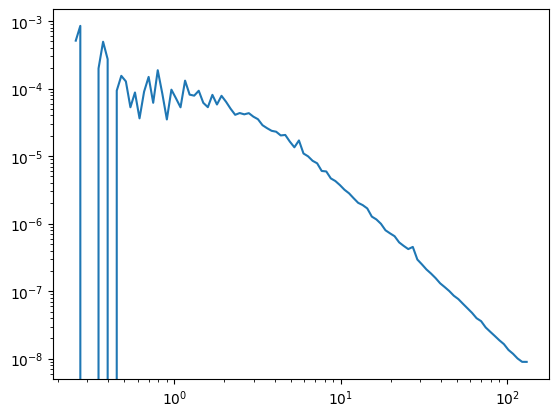

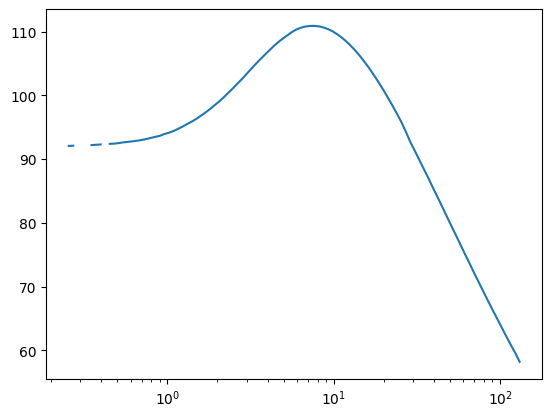

In [4]:
import pynbody as pn
from matplotlib import pyplot as plt
data = pn.load('dianoga_16_gas_only.hdf5')
p = pn.analysis.profile.Profile(data, ndim=3, type='log')
print(p['rbins'])
print(p['density'])
plt.loglog(p['rbins'], p['density'])
plt.show()
plt.plot(p['rbins'], p['u'])
plt.xscale('log')

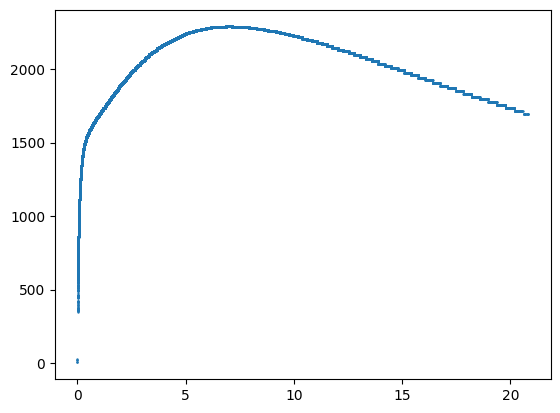

In [10]:
import pynbody as pn
import matplotlib.pyplot as plt
data = pn.load('dSph_truncated_halo.hdf5').gas
#p = pn.analysis.profile.Profile(data.dm, ndim=3, type='log')
#plt.loglog(p['rbins'], p['density'])
#plt.loglog(p['rbins'], density_dm(p['rbins']))
#plt.xlim(1e-2, 1e3)
plt.scatter(data['r'], data['u'], s=0.5)

In [7]:
mass_gas(10000000000000000000)

0.10326533176233424

In [3]:
np.round(mean_particle_separation_DM(r_s_gas/5)*2, 3)

np.float64(0.054)

In [69]:
mass_gas(100000000000000000)

0.09308815492740075

In [35]:
mass_gas(10000000000000)

0.09690519000150476

/work/baw3271/pynbody/pynbody/snapshot/gadgethdf.py:584: RuntimeWarning: No unit information found in GadgetHDF file. Using gadget default units.
  warnings.warn("No unit information found in GadgetHDF file. Using gadget default units.", RuntimeWarning)
/work/baw3271/pynbody/pynbody/snapshot/gadgethdf.py:406: UserWarning: Unable to infer units from HDF attributes
  warnings.warn("Unable to infer units from HDF attributes")
/work/baw3271/pynbody/pynbody/analysis/profile.py:380: RuntimeWarning: invalid value encountered in scalar divide
  result[i] = (name_array * mass_array).sum() / self['weight_fn'][i]


(0.0001, 1.0)

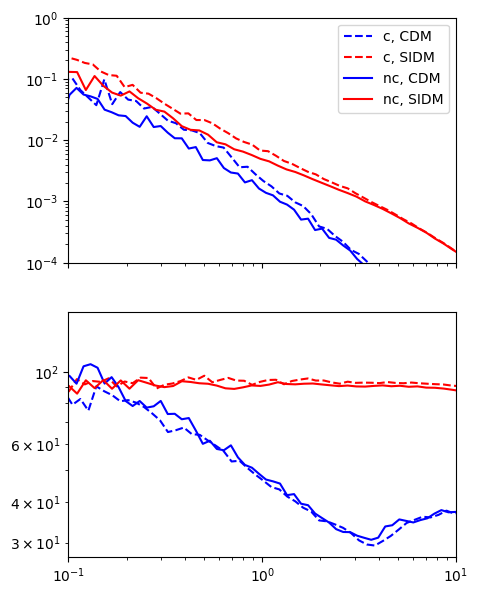

In [17]:
from matplotlib import pyplot as plt
#plt.loglog(r_arr_DM, sigma2_arr_dm)
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5,7]
import pynbody as pn

plt, (ax1, ax2) = plt.subplots(2,1, sharex = True)

ppath = '../Jiang_et_al_2022/dSph_compact/static_baryons/'
snap = '060'
paths = [ppath+'contraction/CDM/data/snapshot_'+snap+'.hdf5', ppath+'contraction/SIDM/data/snapshot_'+snap+'.hdf5',
        ppath+'no_contraction/CDM/data/snapshot_'+snap+'.hdf5', ppath+'no_contraction/SIDM/data/snapshot_'+snap+'.hdf5']
labels = ['c, CDM', 'c, SIDM', 'nc, CDM', 'nc, SIDM']
for i, path in enumerate(paths):
    if i == 0 or i == 1:
        l = '--'
    else:
        l = '-'
    if i == 0 or i == 2:
        c = 'Blue'
    else:
        c = 'red'
    data = pn.load(path)
    p = pn.analysis.profile.Profile(data, ndim=3, type='log')
    ax1.loglog(p['rbins'], p['density'], label=labels[i], linestyle=l, color=c)
    ax2.loglog(p['rbins'], p['v_disp'], label=labels[i], linestyle=l, color=c)
ax1.legend()
ax1.set_xlim(1e-1, 1e1)
ax1.set_ylim(1e-4, 1e0)

<SimSnap "../Jiang_et_al_2022/dSph_compact/static_baryons/no_contraction/CDM/data/snapshot_000.hdf5" len=1000000>


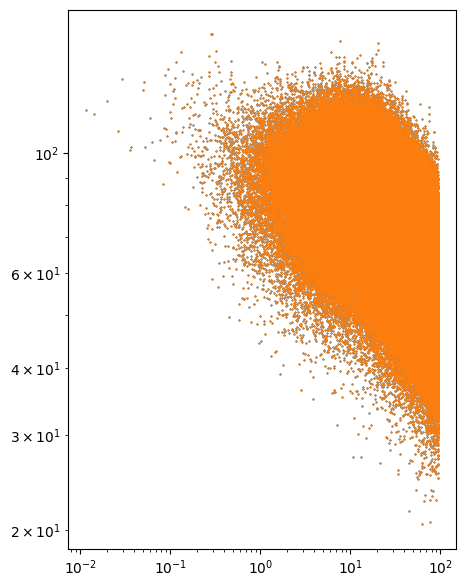

In [61]:
import pynbody as pn
from matplotlib import pyplot as plt
ppath = '../Jiang_et_al_2022/dSph_compact/static_baryons/no_contraction/CDM/data/'
paths = [ppath + 'snapshot_000.hdf5', ppath + 'snapshot_000.hdf5']
for path in paths:
    data = pn.load(path)
    #p = pn.analysis.profile.Profile(data, ndim=3, type='log')
    plt.scatter(data['r'], data['v_disp'], s=0.1)
    plt.xscale('log')
    plt.yscale('log')

print(data)

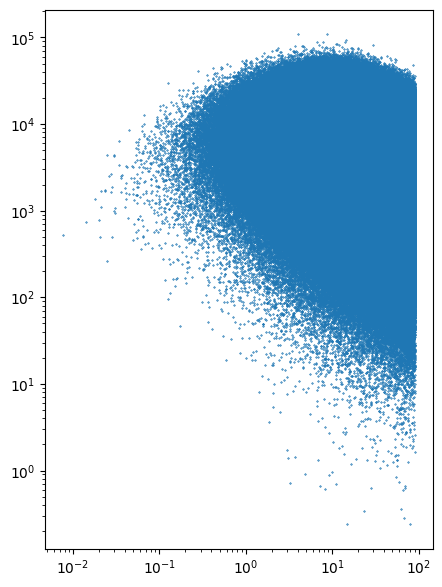

In [65]:
data = pn.load('SIDM10+baryonM_static_no_contr.hdf5')
plt.scatter(data['r'], data['v2'], s=0.1)
plt.xscale('log')
plt.yscale('log')

In [32]:
import configparser

config = configparser.ConfigParser()

config.read('settings.ini')

config = configparser.ConfigParser()
config.read('settings.ini')

# switches
# params
for key, value in config['PARAMS'].items():
    if '.' in value:
        try:
            globals()[key] = float(value)
        except ValueError:
            globals()[key] = value # store as string
    else:
        try:
            globals()[key] = int(value)
        except ValueError:
            globals()[key] = value # store as string

In [7]:
class Profile:
    def __init__(self, profile, *kwargs):
        self.profile = profile

p = Profile(density_gas)

<function __main__.density_gas(r)>

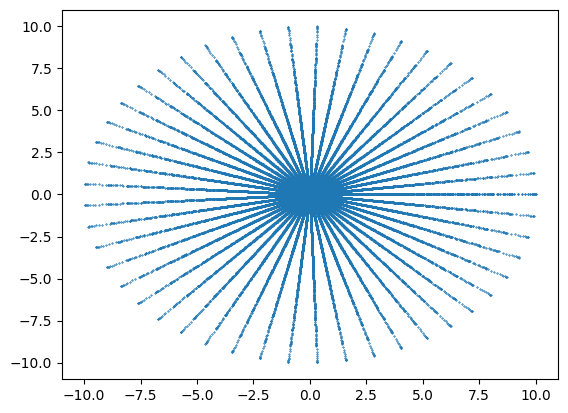

In [28]:
x = np.linspace(0,1)
r = inverse_CPD_Hernquist(x ,1, 1, 10)
phis = np.linspace(0, 2*np.pi)
x = np.linspace(0,1) - 0.5
thetas = np.arccos(-2*x)
#plt.hist(r)
rands = np.random.rand(np.shape(phis))

rs,phis, thetas = np.meshgrid(r, phis, thetas)
x = rs *np.sin(thetas)*np.cos(phis)
y = rs *np.sin(thetas)*np.sin(phis)
z = rs *np.cos(thetas)

plt.scatter(x,y, s=0.1)